Idea for extracting the amplitude and phase difference between SpinTaylorT4 and TaylorF2:
unwrap the ratio? of the two complex waveforms. to get phi1-phi2

In [3]:
# The term you are looking for to find the best choice of parameters when you have data values:
# supervised dimensionality reduction

#shift-tab on a function gets its docstring

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [4]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [5]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)

import constants
imp.reload(constants)
from constants import *

# Make validation and training sets

In [5]:
# These parameters work for ISCO frequency:
mf_min = 0.0008
delta_tbym = 10.0

tbym_tot = 3.0e6
mfon_end = 0.001
mfoff_start = 0.015
mfoff_end = 0.020
mftrunc_start = mfon_end

href_mf_max = 0.03
href_delta_mf = 5.0e-7

ndownsample = 1000

mffit_start = 0.001
mffit_end = 0.0012

In [6]:
# def uniform_grid(n, limits):
#     """
#     """
#     ndim = len(limits)
#     xs_list = []
#     for i in range(ndim):
#         xmin, xmax = limits[i, 0], limits[i, 1]
#         xs = np.linspace(xmin, xmax, n)
#         xs_list.append(xs)
    
#     xs_array = np.array(xs_list)
    
#     print tuple(xs_list)
#     return np.meshgrid(tuple(xs_list))

def uniform_grid(n, limits):
    """This is really stupid.
    """
    points = []
    for i in range(n):
        xmin, xmax = limits[0, 0], limits[0, 1]
        x0 = np.linspace(xmin, xmax, n)
        for j in range(n):
            xmin, xmax = limits[1, 0], limits[1, 1]
            x1 = np.linspace(xmin, xmax, n)
            for k in range(n):
                xmin, xmax = limits[2, 0], limits[2, 1]
                x2 = np.linspace(xmin, xmax, n)
                for l in range(n):
                    xmin, xmax = limits[3, 0], limits[3, 1]
                    x3 = np.linspace(xmin, xmax, n)
                    for m in range(n):
                        xmin, xmax = limits[4, 0], limits[4, 1]
                        x4 = np.linspace(xmin, xmax, n)
                        
                        point = [x0[i], x1[j], x2[k], x3[l], x4[m]]
                        #print point
                        points.append(point)
    #print points
    return np.array(points)

In [7]:
# Parameters for the training set

limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
corners = uniform_grid(2, limits)

Ndata = 512
lhd = doe.latin_hypercube(Ndata, limits)
p_sub = np.concatenate((corners, lhd))

p_sub.shape

(544, 5)

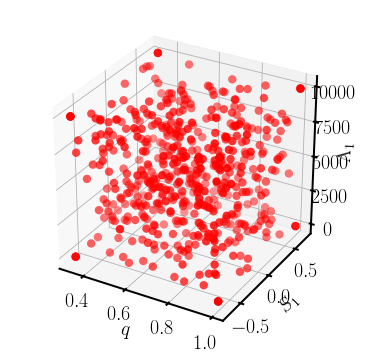

In [10]:
# # ******* plot data *******
# fig = plt.figure(figsize=(14, 6))

# axes = fig.add_subplot(121)
# # xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
# # ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50
# # plot_numbered_points(axes, p_sub)

# axes = fig.add_subplot(122, projection='3d')
# x, y, z = p_sub[:, 0], p_sub[:, 1], p_sub[:, 2]
# axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)

# ******* plot data *******
fig = plt.figure(figsize=(6, 6))
axes = fig.add_subplot(111, projection='3d')
x, y, z = p_sub[:, 0], p_sub[:, 1], p_sub[:, 3]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)
axes.set_xlabel('$q$')
axes.set_ylabel('$S_1$')
axes.set_zlabel('$\Lambda_1$')

In [191]:
spin1x = 0.0
spin1y = 0.0
spin2x = 0.0
spin2y = 0.0
params = np.array([[p_sub[i, 0], spin1x, spin1y, p_sub[i, 1], spin2x, spin2y, p_sub[i, 2], 
                    p_sub[i, 3], p_sub[i, 4]] for i in range(len(p_sub))])

filename = '../data/aligned_training_set.hdf5'

trainset = train.make_td_vs_fd_waveform_set(filename, params, 
                               mf_min, delta_tbym, tbym_tot, 
                               mfon_end, mfoff_start, mfoff_end, 
                               mftrunc_start, 
                               href_mf_max, href_delta_mf, 
                               mffit_start, mffit_end,
                               htapproximant='SpinTaylorT4', hfrefapproximant='TaylorF2')

trainset.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [145]:
# Generate the validation set
q = 0.6
spin2z = 0.3
lambda1 = 2000.0
lambda2 = 1000.0
s1zs = np.linspace(-0.7, 0.7, 101)

spin1x = 0.0
spin1y = 0.0
spin2x = 0.0
spin2y = 0.0
params = np.array([[q, spin1x, spin1y, s1z, spin2x, spin2y, spin2z, lambda1, lambda2] for s1z in s1zs])

filename = '../data/aligned_validation_set.hdf5'

validset = train.make_td_vs_fd_waveform_set(filename, params, 
                               mf_min, delta_tbym, tbym_tot, 
                               mfon_end, mfoff_start, mfoff_end, 
                               mftrunc_start, 
                               href_mf_max, href_delta_mf, 
                               mffit_start, mffit_end,
                               htapproximant='SpinTaylorT4', hfrefapproximant='TaylorF2')
validset.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


In [146]:
# Generate the randomly sampled set
Ndata = 1000
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
p_sub = doe.uniform_random_samples(Ndata, limits)

spin1x = 0.0
spin1y = 0.0
spin2x = 0.0
spin2y = 0.0
params = np.array([[p_sub[i, 0], spin1x, spin1y, p_sub[i, 1], spin2x, spin2y, p_sub[i, 2], 
                    p_sub[i, 3], p_sub[i, 4]] for i in range(len(p_sub))])

filename = '../data/aligned_rand_set.hdf5'

randset = train.make_td_vs_fd_waveform_set(filename, params, 
                               mf_min, delta_tbym, tbym_tot, 
                               mfon_end, mfoff_start, mfoff_end, 
                               mftrunc_start, 
                               href_mf_max, href_delta_mf, 
                               mffit_start, mffit_end,
                               htapproximant='SpinTaylorT4', hfrefapproximant='TaylorF2')
randset.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

# Now open WaveformSets and use them

In [14]:
trainset = ws.HDF5WaveformSet('../data/aligned_training_set.hdf5')
validset = ws.HDF5WaveformSet('../data/aligned_validation_set.hdf5')
randset = ws.HDF5WaveformSet('../data/aligned_rand_set.hdf5')

In [22]:
np.array([trainset[i].x[0] for i in range(len(trainset))]).argmin()

17

In [28]:
trainset[].x

array([ -4.03053871e-03,  -6.07213931e-03,  -8.28389662e-03,
        -8.38327715e-03,  -6.66073951e-03,  -4.64494164e-03,
        -3.52803588e-03,  -3.88669610e-03,  -5.16242382e-03,
        -6.70920255e-03,  -7.98745679e-03,  -8.61387000e-03,
        -8.63658606e-03,  -8.23188207e-03,  -7.60398041e-03,
        -6.93593363e-03,  -6.33374688e-03,  -5.85026340e-03,
        -5.51267554e-03,  -5.32537985e-03,  -5.28716387e-03,
        -5.38391129e-03,  -5.60290126e-03,  -5.98743678e-03,
        -6.52225648e-03,  -7.17168684e-03,  -7.86790807e-03,
        -8.46637545e-03,  -8.77651648e-03,  -8.61340869e-03,
        -7.80115985e-03,  -6.38166225e-03,  -4.71821816e-03,
        -3.35217118e-03,  -3.05184050e-03,  -4.21270775e-03,
        -6.35736222e-03,  -8.40768182e-03,  -8.64587923e-03,
        -6.73315171e-03,  -4.04395725e-03,  -2.87231464e-03,
        -4.95525998e-03,  -7.82320789e-03,  -8.67014085e-03,
        -5.64465064e-03,  -3.00151549e-03,  -4.20428881e-03,
        -7.91351298e-03,

../src/waveform.py:174: RuntimeWarning: divide by zero encountered in log10
  xs = np.logspace(np.log10(xinew), np.log10(xfnew), npoints)
/Users/lackey/Library/Python/2.7/lib/python/site-packages/numpy/core/function_base.py:127: RuntimeWarning: invalid value encountered in multiply
  y = y * step


Exception: xi must be >0 if using 'log' spacing.

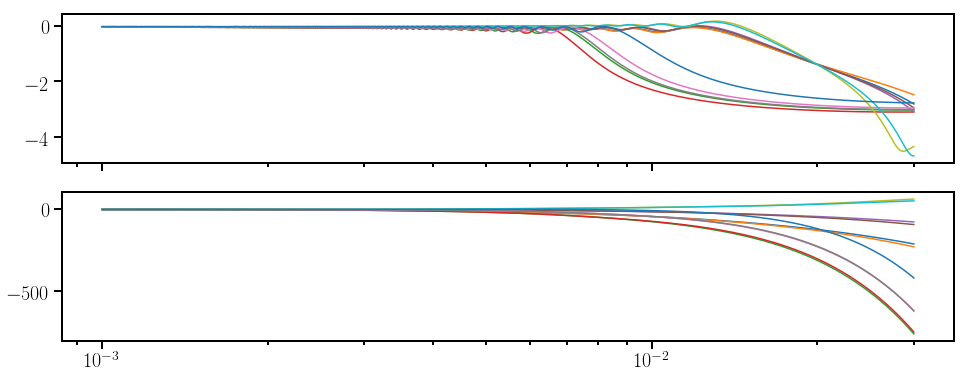

In [17]:
hs = [trainset[i] for i in range(0, len(trainset), 1)]
#fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
fig, (ax1, ax2) = wave.plot_waveforms_fd(hs)
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
#ax1.set_ylim(-0.5, 0.5)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)
ax2.set_xlabel('$Mf$')
ax1.set_ylabel('$\Delta\Phi = \Phi-\Phi_{\rm F2}$')

(0.0001, 0.1)

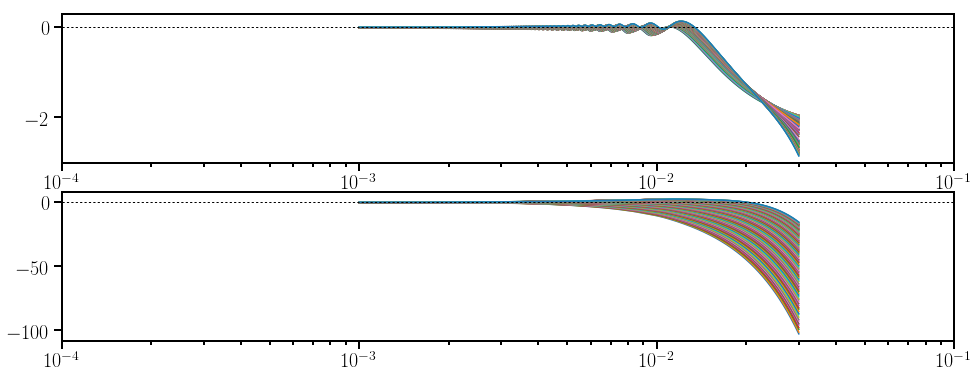

In [199]:
hs = [validset[i] for i in range(len(validset))]
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, hs)
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

(0.0001, 0.1)

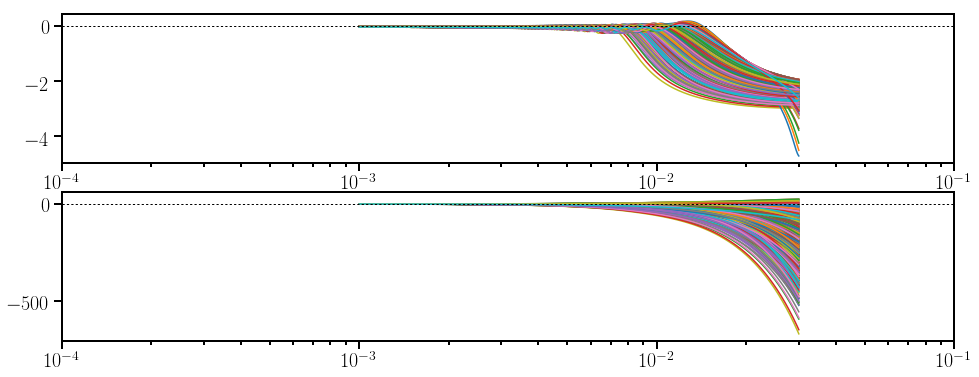

In [200]:
hs = [randset[i] for i in range(0, len(randset), 1)]
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, hs)
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

0.03 2175.27260911


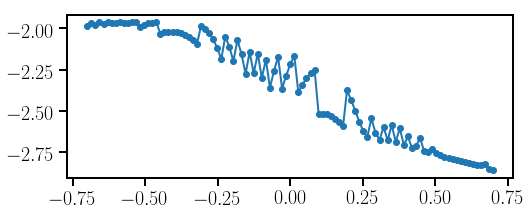

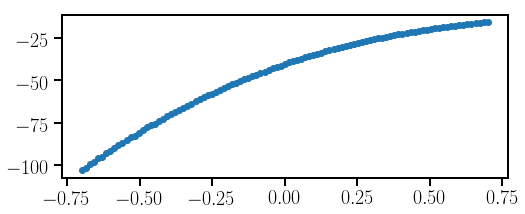

In [15]:
mf = 0.03
print mf, mf_to_f(mf, 2.8)

amps = []
ps = []
for i in range(len(validset)):
    h = validset[i]
    p = validset.get_waveform(i, data='parameters')[3]
    amp = h.interpolate('amp')(mf)
    ps.append(p)
    amps.append(amp)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, amps, 'o', ls='-', lw=2)


phis = []
ps = []
for i in range(len(validset)):
    h = validset[i]
    p = validset.get_waveform(i, data='parameters')[3]
    phi = h.interpolate('phase')(mf)
    ps.append(p)
    phis.append(phi)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phis, 'o', ls='-', lw=2)

# Generate reduced Bases for amplitude and phase

In [16]:
epsilon = 1.0e-6

# Initialize the ReducedBasis object
add = surrogate.add_amp
subtract = surrogate.subtract_amp
scalar_multiply = surrogate.scalar_multiply_amp
inner_product = surrogate.inner_product_amp

get_waveform = trainset.get_waveform

ts_params = trainset.parameters()
rbamprun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbamprun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

/Users/lackey/Library/Python/2.7/lib/python/site-packages/scipy/integrate/quadrature.py:321: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/Users/lackey/Library/Python/2.7/lib/python/site-packages/scipy/integrate/quadrature.py:323: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/Users/lackey/Library/Python/2.7/lib/python/site-packages/scipy/integrate/quadrature.py:323: RuntimeWarning: invalid value encountered in add
  y[slice1]*hsum*hsum/hprod +
/Users/lackey/Library/Python/2.7/lib/python/site-packages/scipy/integrate/quadrature.py:324: RuntimeWarning: invalid value encountered in add
  y[slice2]*(2-h0divh1))


1.0
nan


In [203]:
len(rbamprun.rb)

68

(0.0001, 0.1)

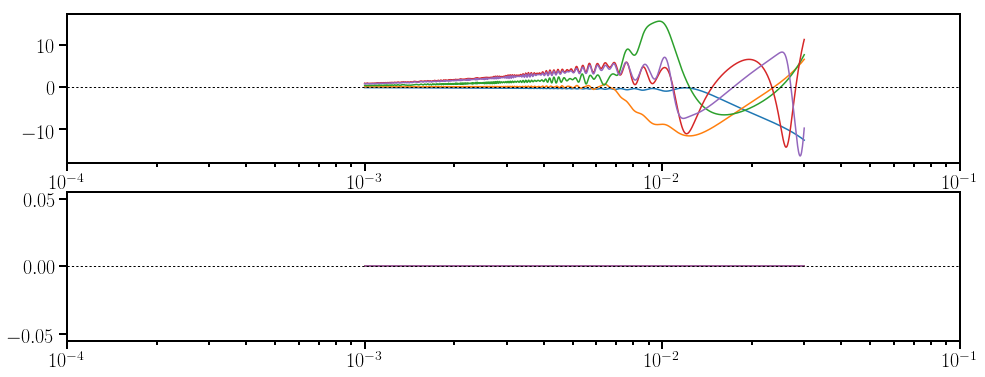

In [204]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, rbamprun.rb[:5])
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

In [205]:
epsilon = 1.0e-8

# Initialize the ReducedBasis object
add = surrogate.add_phase
subtract = surrogate.subtract_phase
scalar_multiply = surrogate.scalar_multiply_phase
inner_product = surrogate.inner_product_phase

get_waveform = trainset.get_waveform

ts_params = trainset.parameters()
rbphaserun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbphaserun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
0.984012292315
0.0461584529803
0.00996848186483
0.000474841038291
0.000184339393352
8.66523644752e-05
2.64663475708e-05
1.9476050356e-05
6.76285962276e-06
5.51651606318e-06
3.23274524483e-06
2.93969670406e-06
2.07039308142e-06
1.52724286306e-06
1.21130578257e-06
8.07931496039e-07
5.39600842564e-07
3.30872290011e-07
3.26995556743e-07
2.84791094374e-07
2.41188020778e-07
2.26396655534e-07
2.05101978179e-07
1.80557817031e-07
1.0519090532e-07
1.0415132623e-07
7.29108868835e-08
6.52800148382e-08
5.67019771136e-08
5.21198458836e-08
4.08949775155e-08
2.80295660016e-08
2.48776690359e-08
2.46315873254e-08
2.39253479251e-08
2.21012227408e-08
1.70862615168e-08
1.37329398964e-08
1.35406403867e-08
1.32116020346e-08
1.25704368026e-08
1.24365208132e-08
1.17485744466e-08
1.1088658658e-08
9.55679002601e-09


In [206]:
len(rbphaserun.rb)

46

(0.0001, 0.1)

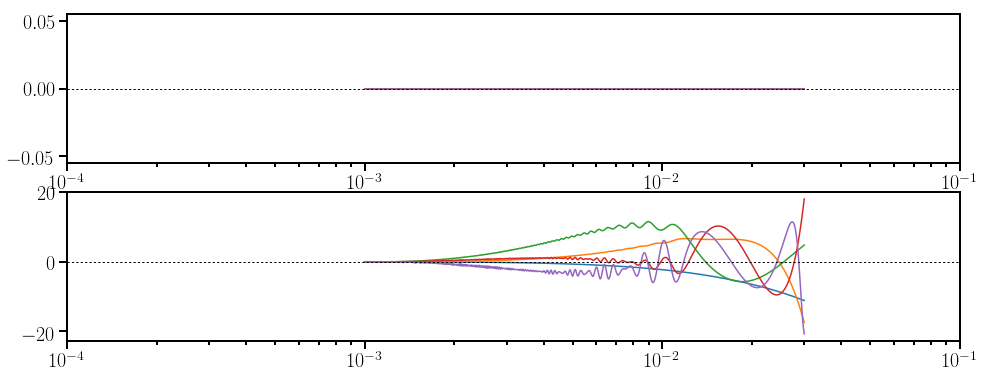

In [207]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, rbphaserun.rb[:5])
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

# Generate Empirical interpolating functions

In [208]:
# Use the first 20 bases
empirical_node_indices_amp, Bamp_j = surrogate.empirical_interpolation_for_time_domain_waveform(rbamprun.rb[:20], 'amp')
empirical_node_indices_phase, Bphase_j = surrogate.empirical_interpolation_for_time_domain_waveform(rbphaserun.rb[:20], 'phase')

In [394]:
def save_empirical_interpolating_function_list(filename, b_j):
    """Save the empirical interpolating functions as a HDF5WaveformSet object.
    """
    bset = ws.HDF5WaveformSet(filename)
    
    for i in range(len(b_j)):
        # Use fake parameters, since the b_j's aren't actual waveforms
        parameters = np.array([0.0])
        bset.set_waveform(i, b_j[i], p)
    
    bset.close()

In [395]:
filename = '../data/Bamp.hdf5'
save_empirical_interpolating_function_list(filename, Bamp_j)

filename = '../data/Bphase.hdf5'
save_empirical_interpolating_function_list(filename, Bphase_j)

In [209]:
# Get the frequencies Mf at each empirical node.
x_amp = Bamp_j[0].x[empirical_node_indices_amp]
x_phase = Bphase_j[0].x[empirical_node_indices_phase]

x_amp, x_phase

(array([ 0.03      ,  0.01254873,  0.00968782,  0.02618046,  0.0194688 ,
         0.00814362,  0.01044132,  0.02774045,  0.00886712,  0.00648263,
         0.00703457,  0.00760756,  0.02899581,  0.00787103,  0.00730302,
         0.00622312,  0.00587316,  0.00670714,  0.00507332,  0.00635155]),
 array([ 0.03      ,  0.02062886,  0.01091383,  0.01555076,  0.02736523,
         0.02479246,  0.02850639,  0.00763351,  0.00825528,  0.00717975,
         0.01026508,  0.00530291,  0.00459635,  0.00905012,  0.02929349,
         0.00603533,  0.00958938,  0.00319303,  0.00670714,  0.00613894]))

(0.0001, 0.1)

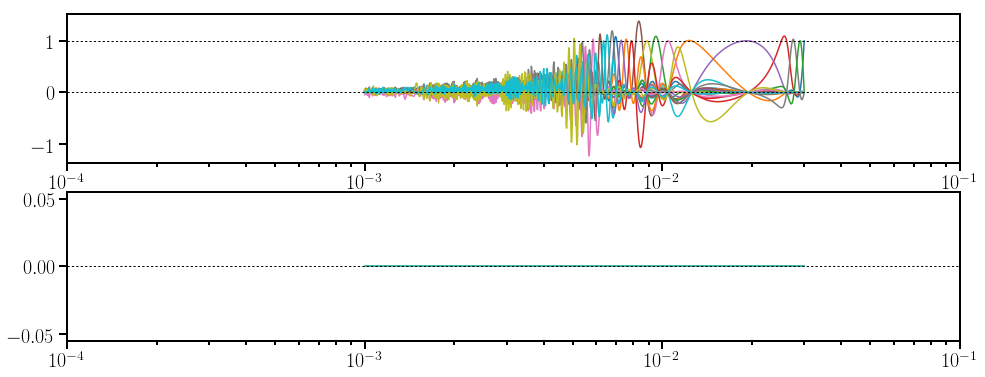

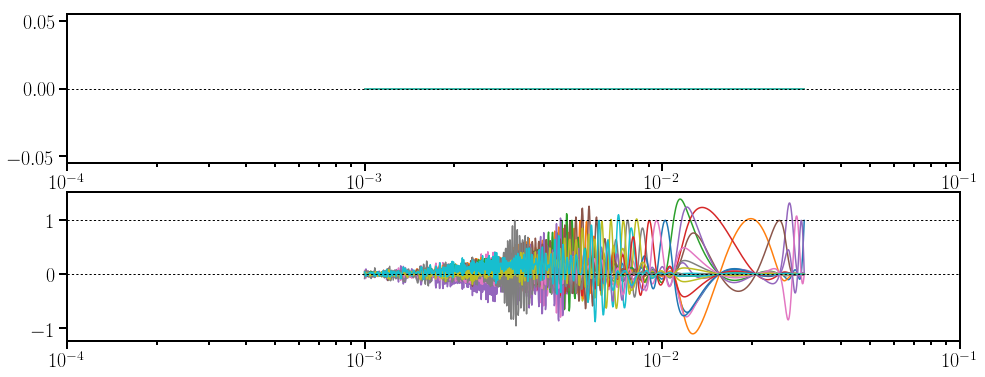

In [210]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, Bamp_j)
ax1.axhline(0, ls=':', c='k', lw=1)
ax1.axhline(1, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, Bphase_j)
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(1, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

# Generate Gaussian processes

In [211]:
# Calculate the amplitude for all waveforms in the training set
# at the amplitude empirical nodes
damp_ts_list = []
for j in range(len(x_amp)):
    mf = x_amp[j]
    damp_ts = np.array([trainset[i].interpolate('amp')(mf) for i in range(len(trainset))])
    damp_ts_list.append(damp_ts)
    
# Calculate the phase for all waveforms in the training set
# at the phase empirical nodes
dphase_ts_list = []
for j in range(len(x_phase)):
    mf = x_phase[j]
    dphase_ts = np.array([trainset[i].interpolate('phase')(mf) for i in range(len(trainset))])
    dphase_ts_list.append(dphase_ts)
    
# Relevant parameters for the training set waveforms
params_ts = trainset.parameters()[:, [0, 3, 6, 7, 8]]

In [213]:
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])

#kernel_type = 'matern32'
kernel_type = 'matern52'
#kernel_type = 'squaredexponential'

damp_gp_list = []
for i in range(len(dphase_ts_list)):
    print i,
    points = params_ts
    data = damp_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits)
    damp_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    print damp_gp.kernel_
    print gpr.get_hyperparameters(damp_gp)
    damp_gp_list.append(damp_gp)

0 1.93**2 * Matern(length_scale=[1.03, 4.11, 3.04, 5.3e+03, 1.83e+04], nu=2.5) + WhiteKernel(noise_level=0.00148)
[  1.92784403e+00   1.02822885e+00   4.11073884e+00   3.03697060e+00
   5.29655352e+03   1.83313579e+04   3.84743057e-02]
1 1**2 * Matern(length_scale=[0.926, 4.46, 5.6, 9.27e+03, 3.68e+04], nu=2.5) + WhiteKernel(noise_level=0.000409)
[  1.00029690e+00   9.26063117e-01   4.45746555e+00   5.60000000e+00
   9.27231425e+03   3.67500748e+04   2.02332435e-02]
2 0.826**2 * Matern(length_scale=[0.84, 2.48, 5.6, 5.72e+03, 2.09e+04], nu=2.5) + WhiteKernel(noise_level=0.000116)
[  8.26486352e-01   8.39827170e-01   2.48470624e+00   5.60000000e+00
   5.71669221e+03   2.09128608e+04   1.07883879e-02]
3 2.27**2 * Matern(length_scale=[1.57, 4.12, 5.6, 7.89e+03, 2.77e+04], nu=2.5) + WhiteKernel(noise_level=0.000582)
[  2.27245508e+00   1.56781241e+00   4.11592475e+00   5.60000000e+00
   7.88964799e+03   2.76674968e+04   2.41253956e-02]
4 0.962**2 * Matern(length_scale=[1.35, 5.6, 5.6, 8.04

In [215]:
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])

#kernel_type = 'matern32'
kernel_type = 'matern52'
#kernel_type = 'squaredexponential'

dphase_gp_list = []
for i in range(len(dphase_ts_list)):
    print i,
    points = params_ts
    data = dphase_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits)
    dphase_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    print dphase_gp.kernel_
    print gpr.get_hyperparameters(dphase_gp)
    dphase_gp_list.append(dphase_gp)

0 256**2 * Matern(length_scale=[1.01, 5.25, 5.6, 2.68e+04, 4e+04], nu=2.5) + WhiteKernel(noise_level=0.0732)
[  2.55723958e+02   1.01492979e+00   5.25050333e+00   5.60000000e+00
   2.67835862e+04   4.00000000e+04   2.70637854e-01]
1 126**2 * Matern(length_scale=[1.11, 4.39, 5.6, 2.79e+04, 4e+04], nu=2.5) + WhiteKernel(noise_level=0.0256)
[  1.25712169e+02   1.11400859e+00   4.39231768e+00   5.60000000e+00
   2.78524419e+04   4.00000000e+04   1.59878590e-01]
2 35.9**2 * Matern(length_scale=[1.28, 3.5, 5.6, 3.94e+04, 4e+04], nu=2.5) + WhiteKernel(noise_level=0.000265)
[  3.58705580e+01   1.28057835e+00   3.50069951e+00   5.60000000e+00
   3.93955434e+04   4.00000000e+04   1.62794120e-02]
3 73.2**2 * Matern(length_scale=[1.2, 3.92, 5.6, 2.99e+04, 4e+04], nu=2.5) + WhiteKernel(noise_level=0.00508)
[  7.31690151e+01   1.19737061e+00   3.92052954e+00   5.60000000e+00
   2.98781794e+04   4.00000000e+04   7.12933489e-02]
4 215**2 * Matern(length_scale=[1.04, 5.02, 5.6, 2.7e+04, 4e+04], nu=2.5)

/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  8.06619049e-04,  -3.47505029e-04,  -6.98816424e-04,
        -4.03394804e+01,  -2.54025424e+01,  -1.51492315e+02,
         4.92894331e-04]), 'nit': 29, 'funcalls': 76}
  " state: %s" % convergence_dict)
/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.77407604e-03,  -7.45673824e-05,  -4.47151398e-04,
        -4.03412432e+01,  -2.54038779e+01,  -1.51492841e+02,
         4.93009249e-04]), 'nit': 31, 'funcalls': 74}
  " state: %s" % convergence_dict)


 30.7**2 * Matern(length_scale=[1.27, 3.39, 5.6, 4e+04, 4e+04], nu=2.5) + WhiteKernel(noise_level=6.18e-07)
[  3.07368955e+01   1.27286714e+00   3.39143120e+00   5.60000000e+00
   4.00000000e+04   4.00000000e+04   7.86157239e-04]
11 8.5**2 * Matern(length_scale=[1.39, 2.66, 5.29, 4e+04, 4e+04], nu=2.5) + WhiteKernel(noise_level=0.000297)
[  8.49675274e+00   1.38908417e+00   2.66426890e+00   5.29285641e+00
   4.00000000e+04   4.00000000e+04   1.72238864e-02]
12 5.81**2 * Matern(length_scale=[1.36, 2.42, 4.95, 4e+04, 4e+04], nu=2.5) + WhiteKernel(noise_level=0.000187)
[  5.81217951e+00   1.35965859e+00   2.42473424e+00   4.94561568e+00
   4.00000000e+04   4.00000000e+04   1.36927781e-02]
13 24.4**2 * Matern(length_scale=[1.34, 3.24, 5.6, 4e+04, 4e+04], nu=2.5) + WhiteKernel(noise_level=0.00013)
[  2.44269609e+01   1.33745125e+00   3.23992547e+00   5.60000000e+00
   4.00000000e+04   4.00000000e+04   1.14156085e-02]
14 245**2 * Matern(length_scale=[1.02, 5.19, 5.6, 2.69e+04, 4e+04], nu=2.5

/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  8.64193395e-04,  -1.19798099e-03,  -8.15588965e-05,
        -4.79200413e+01,  -3.24872535e+01,  -1.52457456e+02,
         4.61879978e-03]), 'nit': 29, 'funcalls': 74}
  " state: %s" % convergence_dict)


 26.9**2 * Matern(length_scale=[1.33, 3.33, 5.6, 4e+04, 4e+04], nu=2.5) + WhiteKernel(noise_level=4.76e-07)
[  2.69240078e+01   1.32833939e+00   3.32926426e+00   5.60000000e+00
   4.00000000e+04   4.00000000e+04   6.89986344e-04]
17 2.41**2 * Matern(length_scale=[1.37, 2.29, 4.62, 4e+04, 4e+04], nu=2.5) + WhiteKernel(noise_level=6.99e-05)
[  2.41329081e+00   1.36720451e+00   2.29088166e+00   4.62384584e+00
   4.00000000e+04   4.00000000e+04   8.36134126e-03]
18 13.5**2 * Matern(length_scale=[1.27, 2.61, 5.55, 4e+04, 4e+04], nu=2.5) + WhiteKernel(noise_level=0.000325)
[  1.34955220e+01   1.26696492e+00   2.60781853e+00   5.55413730e+00
   4.00000000e+04   4.00000000e+04   1.80225509e-02]
19 11.9**2 * Matern(length_scale=[1.3, 2.81, 5.55, 4e+04, 4e+04], nu=2.5) + WhiteKernel(noise_level=0.000183)
[  1.18811379e+01   1.29625446e+00   2.81041754e+00   5.55040086e+00
   4.00000000e+04   4.00000000e+04   1.35363429e-02]


In [ ]:
filename = '../data/amp_gp.hdf5'
gp_list = damp_gp_list
kernel_type = 'matern52'
gpr.save_gaussian_process_regression_list(filename, gp_list, kernel_type)

filename = '../data/phase_gp.hdf5'
gp_list = dphase_gp_list
kernel_type = 'matern52'
gpr.save_gaussian_process_regression_list(filename, gp_list, kernel_type)

0.0194687950459


(0, 1.1)

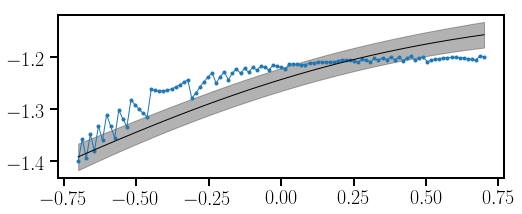

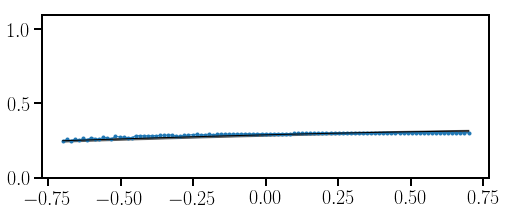

In [219]:
i = 4
mf = x_amp[i]
print mf

params_vs = validset.parameters()[:, [0, 3, 6, 7, 8]]

damp_vs = np.array([validset[j].interpolate('amp')(mf) for j in range(len(validset))])
damp_gp = damp_gp_list[i]
damp_gp_eval, damp_gp_eval_err = damp_gp.predict(params_vs, return_std=True)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params_vs[:, 1], damp_vs, 'o', ls='-', lw=1, ms=3)
axes.plot(params_vs[:, 1], damp_gp_eval, ls='-', lw=1, c='k')
axes.fill_between(params_vs[:, 1], damp_gp_eval-damp_gp_eval_err, damp_gp_eval+damp_gp_eval_err, color='k', alpha=0.3)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params_vs[:, 1], np.exp(damp_vs), 'o', ls='-', lw=1, ms=3)
axes.plot(params_vs[:, 1], np.exp(damp_gp_eval), ls='-', lw=1, c='k')
axes.fill_between(params_vs[:, 1], np.exp(damp_gp_eval-damp_gp_eval_err), np.exp(damp_gp_eval+damp_gp_eval_err), color='k', alpha=0.5)
axes.set_ylim(0, 1.1)

0.0273652272264


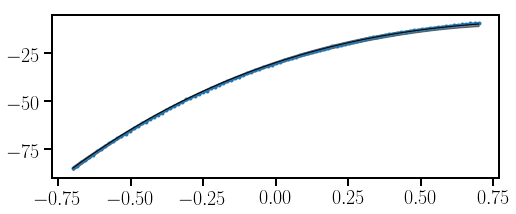

In [220]:
i = 4
mf = x_phase[i]
print mf

dphase_vs = np.array([validset[j].interpolate('phase')(mf) for j in range(len(validset))])
dphase_gp = dphase_gp_list[i]
dphase_gp_eval, dphase_gp_eval_err = dphase_gp.predict(params_vs, return_std=True)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params_vs[:, 1], dphase_vs, 'o', ls='-', lw=1, ms=3)
axes.plot(params_vs[:, 1], dphase_gp_eval, ls='-', lw=1, c='k')
axes.fill_between(params_vs[:, 1], dphase_gp_eval-dphase_gp_eval_err, dphase_gp_eval+dphase_gp_eval_err, color='k', alpha=0.5)

In [233]:
def fractional_amp_error(dlnamp_sur, dlnamp_true):
    """Calculate A_sur/A_true-1 given dlnA_sur and dlnA_true,
    where dlnA_sur = lnA_sur-lnA_ref and dlnA_true = lnA_true-lnA_ref.
    """
    error = np.exp(dlnamp_sur-dlnamp_true)-1.0
    return np.max(np.abs(error))

def phase_error(dphase_sur, dphase_true):
    """Calculate Phi_sur-Phi_true given dPhi_sur and dPhi_true,
    where dPhi_sur = Phi_sur-Phi_ref and Phi_true = Phi_true-Phi_ref.
    """
    error = dphase_sur-dphase_true
    return np.max(np.abs(error))

In [245]:
params_rand = []
amp_err = []
phase_err = []
for i in range(len(randset)):
    hrand = randset[i]
    params = randset.get_waveform(i, data='parameters')[[0, 3, 6, 7, 8]]
    hsur = surrogate.reconstruct_amp_phase_difference(params, Bamp_j, Bphase_j, damp_gp_list, dphase_gp_list)
    
    mfhigh = 0.02
    dlnamp_sur = hsur.amp[hsur.x<=mfhigh]
    dlnamp_true = hrand.amp[hrand.x<=mfhigh]
    dphase_sur = hsur.phase[hsur.x<=mfhigh]
    dphase_true = hrand.phase[hrand.x<=mfhigh]
    
    ae = fractional_amp_error(dlnamp_sur, dlnamp_true)
    pe = phase_error(dphase_sur, dphase_true)
    
    params_rand.append(params)
    amp_err.append(ae)
    phase_err.append(pe)

In [246]:
np.max(amp_err), np.max(phase_err)

(0.3452428468513653, 3.2120009237846716)

In [247]:
i_ampmax = np.array(amp_err).argmax()
i_phasemax = np.array(phase_err).argmax()

In [248]:
params_rand[i_ampmax], params_rand[i_phasemax]

(array([  4.67767583e-01,  -5.28835696e-01,  -5.35300775e-01,
          9.77143096e+03,   9.51674275e+03]),
 array([  3.51163983e-01,  -6.81529745e-01,  -1.31118387e-01,
          9.64538880e+03,   7.70688753e+02]))

[  3.51163983e-01  -6.81529745e-01  -1.31118387e-01   9.64538880e+03
   7.70688753e+02]


(0.0001, 0.1)

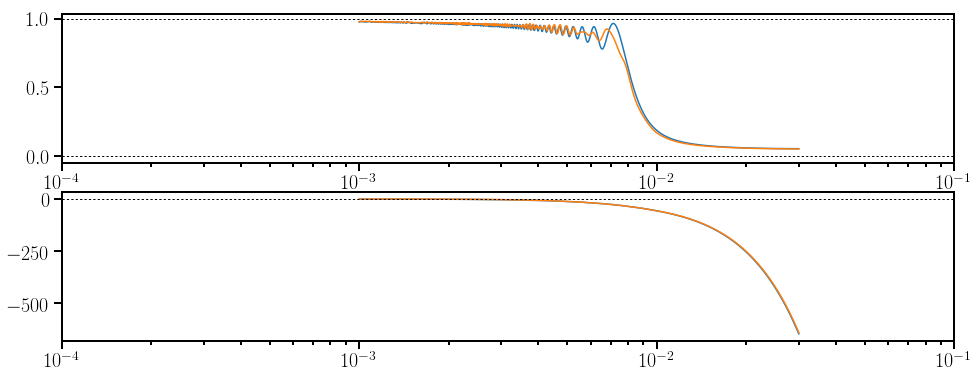

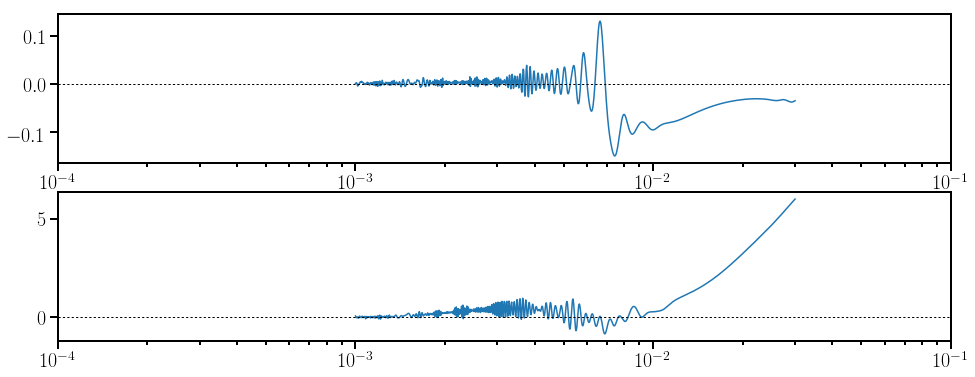

In [249]:
#i = i_ampmax
i = i_phasemax

hrand = randset[i]
params = randset.get_waveform(i, data='parameters')[[0, 3, 6, 7, 8]]
print params
hsur = surrogate.reconstruct_amp_phase_difference(params, Bamp_j, Bphase_j, damp_gp_list, dphase_gp_list)

# Plot h_true and h_sur
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, [hrand, hsur], exp=True)
ax1.axhline(0, ls=':', c='k', lw=1)
ax1.axhline(1, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

# Plot fractional amplitude error and phase error
ae = np.exp(hsur.amp-hrand.amp)-1.0
pe = hsur.phase-hrand.phase
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
ax1.plot(hsur.x, ae)
ax2.plot(hsur.x, pe)
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

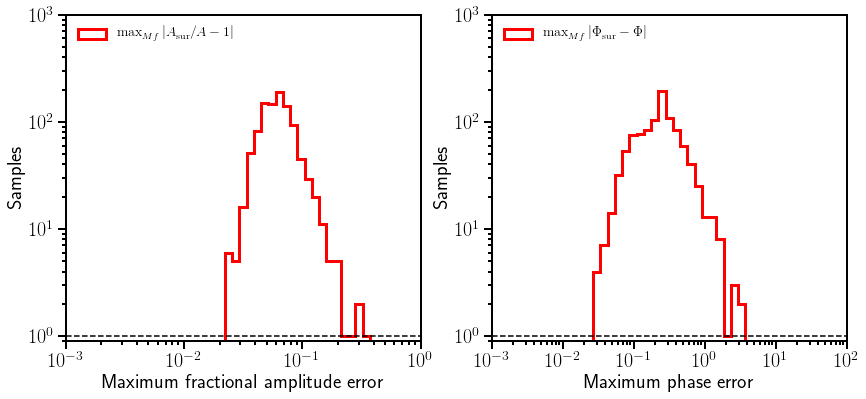

In [253]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.hist(amp_err, bins=np.logspace(-3, 0, 50), histtype='step', 
          ls='-', lw=3, color='red', alpha=1.0, label=r'$\max_{Mf}|A_{\rm sur}/A-1|$')
ax1.axhline(1.0, c='k', ls='--')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1.0e-3, 1.0])
ax1.set_ylim([0.9, 1000])
ax1.set_xlabel('Maximum fractional amplitude error')
ax1.set_ylabel('Samples')
ax1.legend(loc='upper left', frameon=False)

ax2.hist(phase_err, bins=np.logspace(-3, 2, 50), histtype='step', 
          ls='-', lw=3, color='red', alpha=1.0, label=r'$\max_{Mf}|\Phi_{\rm sur}-\Phi|$')
ax2.axhline(1.0, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1.0e-3, 100.0])
ax2.set_ylim([0.9, 1000])
ax2.set_xlabel('Maximum phase error')
ax2.set_ylabel('Samples')
ax2.legend(loc='upper left', frameon=False)

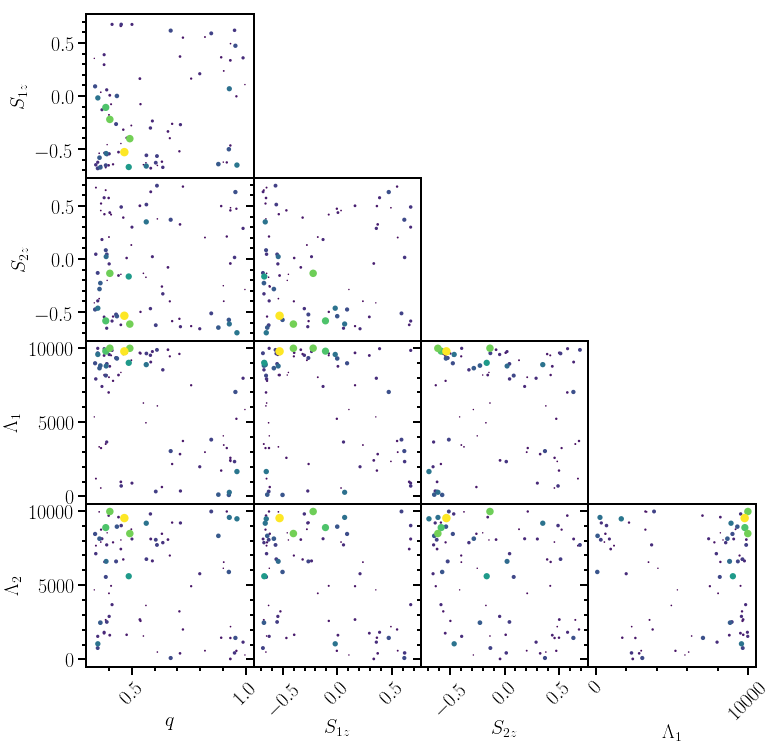

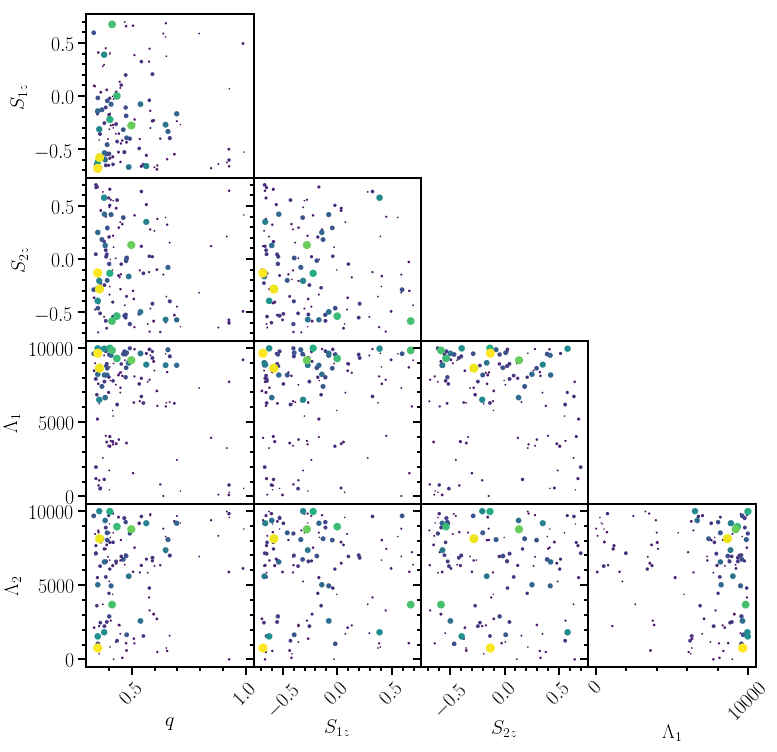

In [281]:
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']
params = params_rand

error = np.array(amp_err)
#print len(error[error>=0.1])
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=0.1, figsize=(10, 10))

error = phase_err
#print len(error[error>=1.0])
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=0.5, figsize=(10, 10))

In [283]:
np.array(error)
#error

(1000,)

# Plot frequency dependent error estimates

In [6]:
Bamp_filename = '../data/Bamp.hdf5'
Bphase_filename = '../data/Bphase.hdf5'
damp_gp_filename = '../data/amp_gp.hdf5'
dphase_gp_filename = '../data/phase_gp.hdf5'

Bamp = ws.HDF5WaveformSet(Bamp_filename)
Bphase = ws.HDF5WaveformSet(Bphase_filename)
damp_gp_list = gpr.load_gaussian_process_regression_list(damp_gp_filename)
dphase_gp_list = gpr.load_gaussian_process_regression_list(dphase_gp_filename)

In [7]:
def error_of_frequency(point, B_j, gp_list, data='amp'):
    jmax = len(B_j)
    eps_f_j = np.array([gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
                        for j in range(jmax)])
    
    # Get complex version of B_j's in array form
    if data=='amp':
        B_j_array = np.array([B_j[j].amp for j in range(jmax)])
    elif data=='phase':
        B_j_array = np.array([B_j[j].phase for j in range(jmax)])
    else:
        raise Exception

    # Evaluate waveform
    error_arr = np.dot(eps_f_j, B_j_array)

    # Rewrite as TimeDomainWaveform
    xarr = B_j[0].x
    return xarr, error_arr

In [11]:
point = np.array([0.8, 0.3, 0.7, 3455, 2579])
#f, eps = error_of_frequency(point, Bamp, damp_gp_list, data='amp')
f, eps = error_of_frequency(point, Bphase, dphase_gp_list, data='phase')

(0.0001, 0.1)

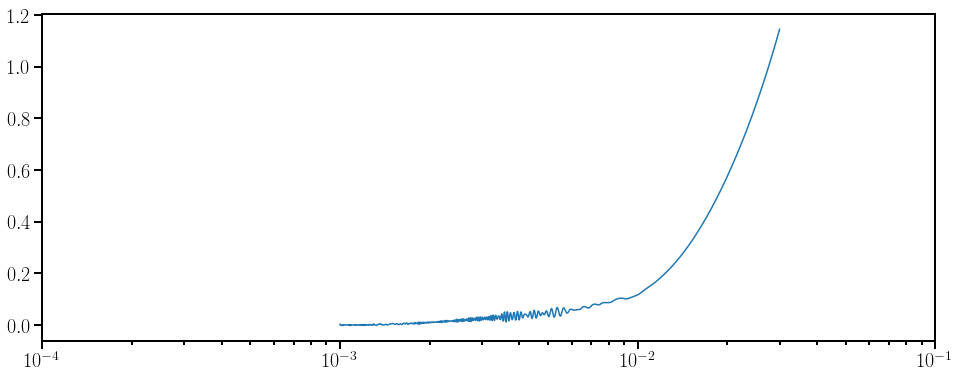

In [12]:
fig, ax1 = plt.subplots(1, figsize=(16, 6))
ax1.plot(f, eps)
ax1.set_xscale('log')
ax1.set_xlim(1.0e-4, 0.1)

# Plot GP functions

In [254]:
def plot_2d_func(axes, func, xlow, xhigh, nx, ylow, yhigh, ny, 
                 interpolation='bicubic', colorbar=True, colorbar_label='z'):
    """Generate a heatmap from the function func.
    """
    # Generate 2d array of z-values
    xs = np.linspace(xlow, xhigh, nx)
    ys = np.linspace(ylow, yhigh, ny)
    zgrid = np.array([[func(x, y) for y in ys] for x in xs])
    
    # Make the plot
    extent = [xs[0], xs[-1], ys[0], ys[-1]]
    im = axes.imshow(zgrid.T, interpolation=interpolation, origin='lower', 
                 extent=extent, aspect='auto')
    
    # Make the colorbar
    if colorbar:
        cb = plt.colorbar(mappable=im, ax=axes)
        cb.set_label(label=colorbar_label)
        
        
def plot_numbered_points(axes, points):
    """
    """
    for i in range(len(points)-1):
        axes.scatter(points[i, 0], points[i, 1], marker='$'+str(i)+'$', s=100, color='r')
        
    axes.scatter(points[-1, 0], points[-1, 1], marker='$'+str(len(points)-1)+'$', s=150, color='orange')

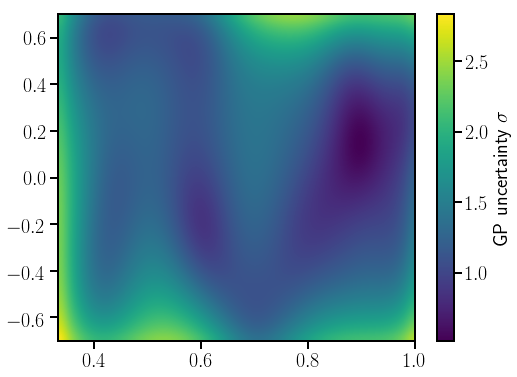

In [263]:
# print maximum_error(func, gp, limits, error_type='absolute', nsample=100000)
# print maximum_error(func, gp, limits, error_type='fractional', nsample=100000)
# print maximum_error(func, gp, limits, error_type='fractional_full_range', nsample=100000)

#x2, x3, x4 = 0.4, 5000.0, 5000.0
x0, x1, x2, x3, x4 = params_rand[i_phasemax]
def gp_predict_error(x0, x1):
    i = 0
    return dphase_gp_list[i].predict(np.array([[x0, x1, x2, x3, x4]]), return_std=True)[1][0]

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50
points = params_ts
plot_2d_func(ax1, gp_predict_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'GP uncertainty $\sigma$')
#plot_numbered_points(ax1, points)

0.0109138278194


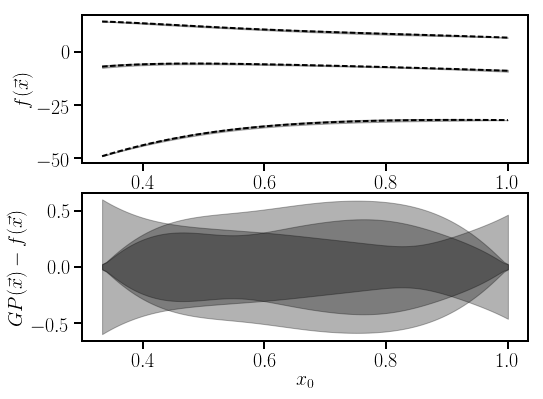

In [269]:
#x2, x3, x4 = 0.0, 2000.0, 2000.0
#x0, x1, x2, x3, x4 = params_rand[i_phasemax]
x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0.0, 0.0
i = 2
mf = x_phase[i]
print mf
gp = dphase_gp_list[i]

fig, ax = plt.subplots(2, figsize=(8, 6))
for x1 in np.linspace(-0.7, 0.7, 3):
    x0s = np.linspace(1.0/3.0, 1.0, 100)
    ps = np.array([[x0, x1, x2, x3, x4] for x0 in x0s])
    
    #true = np.array([func(p) for p in ps])
    #ax[0].plot(xs, true, label=r'$x_1$='+str(x1))
    
    y_pred, ysigma = gp.predict(ps, return_std=True)
    ax[0].plot(x0s, y_pred, c='k', ls='--', lw=2)
    ax[0].fill_between(x0s, y_pred-ysigma, y_pred+ysigma, color='k', alpha=0.3)
    
    #ax[1].plot(x0s, (y_pred-true), label=r'$x_1$='+str(x1))
    ax[1].fill_between(x0s, -ysigma, ysigma, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))

In [278]:
n_new = 10
i=0
hp0 = gpr.get_hyperparameters(dphase_gp_list[i])
new_points = gpr.sample_n_new_points_with_fixed_hyperparameters(n_new, points, limits, hp0, kernel_type, nsamples=1000000)

0 1 2 3 4 5 6 7 8 9


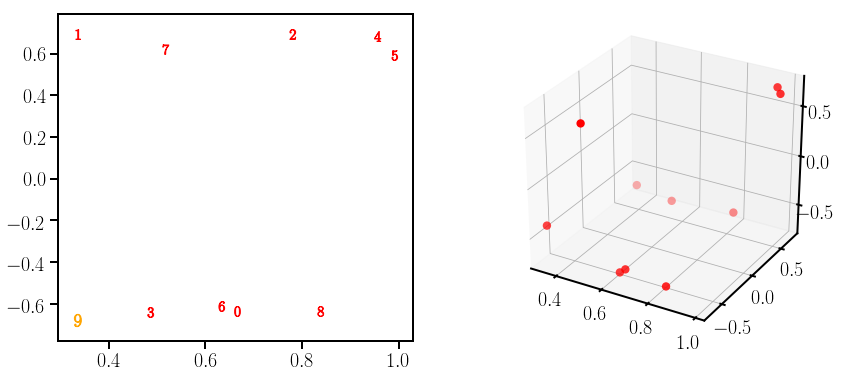

In [279]:
# ******* plot data *******
fig = plt.figure(figsize=(14, 6))

axes = fig.add_subplot(121)
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50
plot_numbered_points(axes, new_points)

axes = fig.add_subplot(122, projection='3d')
x, y, z = new_points[:, 0], new_points[:, 1], new_points[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)

# Uncertainty sampling

In [ ]:
class UncertaintySampling(object):
    def __init__(damp_gp_list, dphase_gp_list):
        """
        Parameters
        ----------
        objective_function(point, *args, **kwargs)
        """
        self.objective_function=objective_function
        
    def 

In [1]:
def objective_function(point, damp_gp_list, dphase_gp_list):
    """Objective function to minimize when searching for new training set points.
    This function provides an estimate of the error.
    """
    
    namp_nodes = len(damp_gp_list)
    nphase_nodes = len(dphase_gp_list)
    
    # Calculate waveform at nodes
    sigma_amp_j = np.array([damp_gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
                             for j in range(namp_nodes)])
    sigma_phase_j = np.array([dphase_gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
                               for j in range(nphase_nodes)])
    
    sigma_amp_sq = np.sum(sigma_amp_j)**2
    sigma_phase_sq = np.sum(sigma_phase_j)**2
    
    return sigma_amp_sq + sigma_phase_sq
    
    
def update_gp_uncertainty_function(gp, kernel_type, new_point):
    """Update the Gaussian Process Regression 
    error estimate after adding the new point.
    """
    hyper_params = gpr.get_hyperparameters(gp)
    old_points = gp.X_train_
    points = np.concatenate((old_points, np.atleast2d(new_point)))
    # Generate fake data, because the uncertainty estimate doesn't depend on the data.
    data = np.ones(len(points))
    gp_new = generate_gp(points, data, hyper_params, fixed=True, kernel_type=kernel_type)
    return gp_new

def update_objective_function():

In [ ]:
def sample_new_point(limits, objective_function, *args, **kwargs, nsamples=100000):
    """Get new point using uncertainty sampling.
    The points are needed but the data is not, because the GPR uncertainty
    does not depend on the data.

    Parameters
    ----------
    objective_function(point, *args, **kwargs)
    nsamples : int
        number of random points to search for largest GPR uncertainty.

    Returns
    -------
    point_new : The new point
    """
    # ******* Perform uncertainty sampling *******
    # --Find the point with the maximum uncertainty given the current Gaussian process.
    # --For now use Monte Carlo sampling.
    # --Later, do a multistart optimization.
    test_points = doe.uniform_random_samples(nsamples, limits)
    test_errs = np.array([objective_function(p, *args, **kwargs) for p in test_points])
    i_max = np.argmax(test_errs)
    point_new = test_points[i_max]

    #print np.max(test_errs)

    return point_new, gp


def sample_n_new_points_with_fixed_hyperparameters(n_new, points, limits, hp0, kernel_type, nsamples=100000):
    """Get n_new new points.
    """
    points_updated = copy.copy(points)

    for i in range(n_new):
        print i,
        # Find the best location for the new point
        point_new, gp = sample_new_point_with_fixed_hyperparameters(points_updated, limits, hp0, kernel_type,
                                                                    nsamples=nsamples)

        # Add the new point to the list of updated points
        points_updated = np.concatenate((points_updated, np.atleast_2d(point_new)))

    # Return just the new points that you added
    return points_updated[-n_new:]
